<a href="https://colab.research.google.com/github/puneat/Audio_Sentiment/blob/master/gender_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
# Importing required libraries 
# Keras
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Other  
import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
import glob 
import os
from tqdm import tqdm
import pickle
import IPython.display as ipd  # To play sound in the notebook

In [ ]:
df_male= pd.read_csv('/gdrive/My Drive/Audio_files/Combined_Dataframes/gender_male.csv')
df_female= pd.read_csv('/gdrive/My Drive/Audio_files/Combined_Dataframes/gender_female.csv')

In [ ]:
df_male=df_male.drop(['path','source'],axis=1)

In [ ]:
df_female=df_female.drop(['path','source'],axis=1)

In [ ]:
#converting class into boolean as male=1 and female=2
for i in range(0,df_male.shape[0]):
  if df_male['labels'][i]=='male':
    df_male['labels'][i]=1;

#typecasting as integer
#df['label']=df['label'].astype(int)

In [ ]:
#converting class into boolean as male=1 and female=2
for i in range(0,df_female.shape[0]):
  if df_female['labels'][i]=='female':
    df_female['labels'][i]=2;

#typecasting as integer
#df['label']=df['label'].astype(int)

In [ ]:
df_male.head()

,labels,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215
0,1,-17.685801,-10.543401,-7.518024,-7.506939,-7.403337,-7.362275,-8.112685,-6.900735,-7.539663,-7.677543,-8.266721,-9.299829,-10.524870,-15.049426,-19.683942,-19.050067,-18.667913,-20.895418,-23.388832,-23.887907,-25.020802,-26.581469,-20.918649,-14.350466,-11.566920,-9.683457,-9.573993,-10.763644,-11.851552,-13.374164,-16.865402,-20.377562,-23.882169,-25.583794,-24.624932,-25.183511,-24.761721,-17.923752,-10.733843,...,-9.427887,-8.050047,-6.875153,-6.847067,-7.501703,-11.273141,-15.233299,-17.738540,-21.600643,-23.349737,-22.254533,-23.589939,-25.336841,-25.831961,-27.366389,-26.924206,-26.831335,-27.003823,-24.906468,-24.816904,-25.608896,-25.390564,-27.034643,-26.252514,-26.358090,-27.220914,-28.279947,-26.211946,-25.694268,-25.985311,-25.768369,-24.080482,-23.160257,-23.539012,-23.789283,-25.096969,-24.103728,-22.289075,-23.330710,-23.340112
1,1,-25.302001,-24.328179,-24.939580,-24.932921,-15.922182,-9.669080,-9.113287,-10.833799,-10.096997,-8.566569,-8.906033,-7.871860,-9.418822,-10.009119,-10.193020,-10.780454,-10.459806,-10.747662,-11.497913,-11.451850,-11.062868,-10.295214,-10.414422,-10.493700,-10.004488,-11.568353,-12.606366,-12.271651,-11.122537,-10.865031,-10.775224,-11.461333,-13.333211,-14.883215,-17.008620,-20.033215,-20.588206,-22.697601,-25.071752,...,-7.462429,-7.808964,-7.672180,-8.076372,-7.451515,-7.493429,-7.403017,-7.776670,-6.474336,-5.761596,-5.537273,-4.615541,-4.275374,-5.860197,-6.728284,-8.172176,-9.817752,-10.770730,-12.146788,-13.995520,-16.950673,-18.689850,-20.579320,-23.219597,-24.630404,-24.744938,-16.205772,-9.773642,-7.804234,-8.606250,-9.588616,-10.779072,-11.047021,-10.245645,-9.663476,-10.854288,-12.546134,-11.642432,-8.647266,-5.034869
2,1,-26.134152,-23.928131,-23.992998,-23.687232,-26.934288,-24.934039,-23.083398,-22.089126,-21.178202,-22.035588,-22.058052,-19.109700,-10.477399,-7.028228,-7.245320,-8.266217,-9.508348,-11.043246,-14.196529,-14.606633,-14.755610,-14.234541,-13.836773,-13.709015,-11.730912,-9.817653,-9.181870,-9.086506,-9.177656,-7.936095,-9.395794,-14.276868,-18.127514,-19.903403,-20.081414,-20.061916,-20.509237,-21.866830,-22.893465,...,-4.992591,-5.144972,-5.176300,-5.508100,-6.291518,-6.860570,-7.429581,-7.177023,-6.804778,-5.958700,-5.029949,-4.818337,-5.642507,-6.503660,-6.522467,-5.039698,-3.914023,-3.551429,-5.201806,-9.454711,-13.561260,-15.706702,-18.843068,-22.448579,-24.795962,-26.733256,-25.171927,-25.426535,-25.577378,-22.829461,-12.367325,-10.398124,-9.959911,-11.010429,-10.773854,-11.549666,-11.601620,-11.788002,-8.063619,-4.384248
3,1,-24.981074,-23.702246,-24.368539,-23.824286,-20.085265,-20.491522,-21.797198,-20.689136,-14.338272,-11.482922,-10.521439,-12.182463,-11.595602,-12.030412,-12.058803,-11.096145,-11.726163,-12.529537,-11.746328,-12.215391,-11.619400,-9.801078,-9.414315,-9.077748,-8.705984,-9.851240,-13.996290,-19.624007,-20.968213,-22.996743,-25.072632,-24.864131,-23.185258,-21.814228,-21.784198,-23.577666,-19.323375,-11.703538,-8.495196,...,-16.178072,-9.391094,-8.730066,-7.953388,-7.110306,-6.925129,-8.492684,-9.398223,-8.185889,-6.323172,-5.538038,-8.082038,-12.421711,-16.895500,-20.280909,-21.456681,-21.099407,-18.585644,-17.797974,-19.957557,-23.856652,-24.464547,-24.439857,-24.845373,-25.096150,-21.645310,-14.021650,-11.428354,-12.111615,-11.454638,-11.261946,-12.151451,-13.157601,-13.586169,-14.426998,-15.093403,-13.683900,-13.934830,-9.288823,-4.696516
4,1,-27.752265,-25.923429,-24.471903,-25.061312,-25.652226,-24.637138,-12.599761,-9.450301,-7.799275,-6.569584,-6.787066,-8.992010,-14.182813,-16.295075,-17.691677,-19.408622,-21.909069,-22.078380,-23.051467,-17.387743,-9.911794,-6.025359,-6.154556,-8.081390,-7.912606,-7.205441,-7.030226,-7.278397,-6.924427,-7.

In [ ]:
df_female.head()

,labels,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215
0,2,-18.165691,-22.280521,-32.869496,-33.348384,-31.442652,-31.226946,-32.970442,-33.405853,-35.146622,-35.080820,-32.162143,-32.314888,-33.737759,-33.069504,-31.279293,-31.751031,-31.841785,-31.157676,-30.931237,-30.124957,-29.782879,-32.158049,-32.337431,-30.675274,-31.730434,-34.623561,-35.976177,-37.867385,-38.295264,-38.250943,-39.129616,-38.524891,-39.097919,-39.864353,-38.091470,-37.163623,-35.982447,-23.263903,-15.101242,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,-15.906002,-20.206035,-36.018307,-35.941433,-33.626322,-31.863684,-34.244930,-32.479571,-32.478172,-33.285993,-34.209077,-36.464251,-36.647254,-35.330317,-34.510329,-33.729459,-32.513479,-33.482710,-35.434165,-35.072211,-33.458010,-33.214199,-34.357680,-33.464561,-32.515809,-31.309234,-33.015302,-35.088208,-33.007208,-31.246055,-29.818128,-28.506141,-28.294383,-31.134243,-33.071401,-34.568117,-35.536651,-35.618307,-36.944146,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,-35.817310,-33.259054,-34.746449,-37.156902,-35.278470,-35.749107,-34.313131,-32.307477,-31.753337,-31.757874,-32.536862,-33.188495,-33.653722,-34.297734,-34.124224,-32.213580,-33.118894,-34.356938,-34.071390,-34.237020,-33.910608,-33.379212,-33.951564,-32.991469,-31.926951,-31.510142,-31.347825,-33.509127,-36.204372,-36.973021,-35.409051,-30.808756,-30.061974,-31.426117,-32.489891,-33.225080,-34.988262,-33.949857,-31.391070,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2,-16.569900,-20.540696,-31.054675,-30.003052,-29.991817,-31.160669,-33.608597,-35.381098,-37.277302,-35.547838,-32.533438,-32.138186,-31.699817,-32.305732,-32.739847,-31.672572,-30.828298,-32.681893,-31.391616,-28.571363,-29.069535,-33.257574,-32.603988,-31.257130,-32.009569,-36.388628,-40.161109,-40.646639,-40.015500,-40.219691,-37.696075,-34.306881,-32.456394,-30.557606,-27.925781,-22.087268,-20.069869,-20.049239,-18.357433,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2,-14.927656,-19.177805,-32.440822,-32.021896,-32.209691,-34.273317,-35.611009,-35.120896,-32.919323,-32.953254,-33.469782,-34.013599,-35.458182,-36.381816,-36.383833,-36.746485,-35.774530,-35.460933,-34.599711,-33.887741,-34.201649,-35.844957,-34.925646,-33.970445,-34.496503,-34.793064,-34.780491,-36.446122,-35.125235,-33.393734,-33.592417,-32.474319,-32.628319,-34.141552,-36.960046,-40.569463,-43.847191,-42.913318,-40.391468,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
print(df_male.shape,df_female.shape)

(30780, 217) (42174, 217)


In [ ]:
frames=[df_male,df_female];
gender=pd.concat(frames);

In [ ]:
gender.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72954 entries, 0 to 42173
Columns: 217 entries, labels to 215
dtypes: float64(216), object(1)
memory usage: 121.3+ MB


In [ ]:
#shuffling for randomization
gender = gender.sample(frac=1).reset_index(drop=True)

In [ ]:
gender.tail(10)

,labels,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215
72944,1,-10.670418,-11.150011,-13.439822,-13.967473,-12.670684,-11.883726,-12.690863,-13.844578,-15.474143,-15.499341,-12.458948,-11.482914,-10.093655,-10.857649,-11.000305,-12.150591,-12.120232,-13.092622,-10.954196,-8.746263,-8.883431,-11.674540,-13.639603,-13.160039,-10.519193,-9.630203,-12.277923,-13.213113,-12.588486,-10.415010,-10.604408,-10.291978,-9.929912,-11.491751,-12.978033,-12.678137,-13.043512,-14.329350,-14.954522,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
72945,2,-17.665789,-20.447879,-22.264629,-22.077285,-24.424704,-20.611456,-19.377541,-20.237834,-20.152100,-19.669637,-19.495254,-18.193196,-19.008050,-20.659122,-22.895052,-22.909739,-24.038937,-26.563605,-22.582504,-18.918213,-20.349023,-22.306145,-21.604035,-19.884670,-21.928155,-25.170077,-23.452963,-21.295030,-19.704778,-19.375682,-19.136822,-17.463816,-16.296172,-16.682356,-18.782751,-17.579886,-18.326031,-22.776161,-23.320231,...,-49.352622,-37.803051,-25.252692,-22.394297,-21.829616,-20.362624,-19.978956,-20.289565,-21.699010,-21.874400,-17.254949,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
72946,2,-15.143509,-15.854057,-17.096053,-19.293556,-16.497683,-15.334623,-15.864093,-19.096987,-19.625943,-15.737345,-16.709125,-19.956421,-18.782743,-15.821259,-16.475246,-17.580521,-18.747988,-18.217798,-17.712024,-17.392177,-17.639321,-19.915124,-21.577539,-19.505348,-17.517811,-17.211135,-16.121713,-17.904676,-19.585729,-17.745355,-15.883982,-16.361370,-17.405833,-16.658023,-18.017480,-19.307125,-17.084110,-16.644703,-16.291452,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
72947,1,-2.396879,-7.596360,-19.055376,-17.543345,-16.992860,-20.110046,-19.170515,-19.006401,-19.697315,-18.793940,-17.609824,-17.632760,-19.005787,-18.488997,-18.353486,-19.701574,-18.733689,-18.927901,-20.851059,-22.062695,-19.860501,-18.278097,-16.773562,-16.146154,-14.187962,-12.612381,-12.136117,-12.353489,-13.181806,-13.256414,-14.501938,-15.882539,-15.290710,-16.637172,-15.884311,-16.665217,-15.676579,-12.962661,-13.922989,...,-20.891507,-21.161045,-23.250997,-26.435107,-33.545073,-39.936604,-40.418559,-40.418559,-40.418559,-40.418559,-40.418559,-40.418559,-40.418559,-40.418559,-40.418559,-40.418559,-40.418559,-40.418559,-40.418559,-40.418559,-40.418559,-40.418559,-40.418559,-40.418559,-40.418559,-40.418559,-40.418559,-40.418559,-40.418559,-40.418559,-40.418559,-40.418559,-40.418559,-40.418559,-40.418559,-40.418559,-40.418559,-40.418559,-40.418559,-40.418559
72948,1,-67.405043,-67.405043,-67.405043,-67.405043,-67.405043,-67.405043,-67.405043,-67.405043,-67.368484,-67.405043,-67.405043,-67.506983,-66.695647,-64.568457,-66.161877,-67.412554,-65.281046,-64.583527,-64.046599,-65.825340,-67.405043,-67.405043,-67.405043,-67.405043,-67.378821,-66.991290,-65.156769,-66.308665,-66.111812,-63.749577,-61.502731,-59.253196,-49.964604,-40.993331,-35.552081,-32.565233,-32.325161,-33.86

In [ ]:
X = gender.iloc[:, 1:217].values
y = gender.iloc[:,0].values
print('Dimensions of input features, X is: '+ str(X.shape))
print('Dimensions of output labels, y is: '+ str(y.shape))

Dimensions of input features, X is: (72954, 216)
Dimensions of output labels, y is: (72954,)


In [ ]:
#one hot encoding
encoder = LabelEncoder()
encoder.fit(y)
encoded_Y = encoder.transform(y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)

In [ ]:
#Using sci-kit's train_test split function
np.random.seed(0) # setting a seed value for reproducibility of results
X_train, X_test, y_train, y_test = train_test_split(X, dummy_y, test_size=0.20)
print('Rows in training data : '+ str(X_train.shape[0]))
print('Rows in testing data : '+ str(X_test.shape[0]))

Rows in training data : 58363
Rows in testing data : 14591


In [ ]:
from sklearn import preprocessing
X_scaler = preprocessing.MinMaxScaler();
X_train = X_scaler.fit_transform(X_train); # fit_transform calls fit() and then transform()
X_scaler.transform(X_test); #fit() already called

In [ ]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(58363, 216, 1)

## **RESNET**

In [ ]:
np.random.seed(4) #seeding to replicate results
adam = optimizers.Adam(lr=0.001) # learning rate defiined manually for Adam optimizer
model = Sequential()
model.add(Reshape((216,1), input_shape=(X_train.shape[1],)))
model.add(Conv1D(100, 15, activation='relu', input_shape=(512,1)))
model.add(Conv1D(150, 7, activation='relu'))
model.add(Conv1D(75, 3, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(64, 1, activation='relu'))
model.add(Conv1D(64, 1, activation='relu'))
model.add(Conv1D(128, 1, activation='relu'))
model.add(Conv1D(128, 1, activation='relu'))
model.add(Conv1D(128, 1, activation='relu'))
model.add(Conv1D(128, 1, activation='relu'))
model.add(GlobalAveragePooling1D())
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 216, 1)            0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 202, 100)          1600      
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 196, 150)          105150    
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 194, 75)           33825     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 64, 75)            0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 64, 64)            4864      
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 64, 64)           

## **1D CNN**

In [ ]:
# New model
model = Sequential()
model.add(Conv1D(128, 8, padding='same',input_shape=(X_train.shape[1],1)))  # X_train.shape[1] = No. of Columns
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 4, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 4, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 4, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 4, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(32, 4, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(32, 4, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
#model.add(Dense(64)) # Target class number
#model.add(Activation('relu'))
#model.add(Dense(64)) # Target class number
#model.add(Activation('relu'))
model.add(Dense(2)) # Target class number
model.add(Activation('softmax'))
opt = keras.optimizers.adam(lr=0.0005, amsgrad=True)
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_69 (Conv1D)           (None, 216, 128)          1152      
_________________________________________________________________
activation_61 (Activation)   (None, 216, 128)          0         
_________________________________________________________________
conv1d_70 (Conv1D)           (None, 216, 128)          131200    
_________________________________________________________________
batch_normalization_13 (Batc (None, 216, 128)          512       
_________________________________________________________________
activation_62 (Activation)   (None, 216, 128)          0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 216, 128)          0         
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 27, 128)         

In [ ]:
# fit network
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model_history=model.fit(X_train, y_train , epochs=200, batch_size=16, verbose=1,validation_data=(X_test, y_test))

Train on 58363 samples, validate on 14591 samples
Epoch 1/200
58363/58363 [==============================] - 37s 633us/step - loss: 0.5193 - accuracy: 0.7095 - val_loss: 44.4867 - val_accuracy: 0.4603
Epoch 2/200
58363/58363 [==============================] - 35s 607us/step - loss: 0.4549 - accuracy: 0.7580 - val_loss: 186.8452 - val_accuracy: 0.4894
Epoch 3/200
58363/58363 [==============================] - 35s 608us/step - loss: 0.4296 - accuracy: 0.7761 - val_loss: 178.2883 - val_accuracy: 0.4506
Epoch 4/200
58363/58363 [==============================] - 35s 604us/step - loss: 0.4156 - accuracy: 0.7838 - val_loss: 241.9551 - val_accuracy: 0.3854
Epoch 5/200
58363/58363 [==============================] - 35s 607us/step - loss: 0.4067 - accuracy: 0.7939 - val_loss: 186.6180 - val_accuracy: 0.3816
Epoch 6/200
58363/58363 [==============================] - 35s 602us/step - loss: 0.3971 - accuracy: 0.7985 - val_loss: 222.0656 - val_accuracy: 0.4055
Epoch 7/200
58363/58363 [==============

In [ ]:
cd /gdrive/My Drive/Audio_files/

/gdrive/My Drive/Audio_files


In [ ]:
# Save model and weights
model_name = 'gender_cnn.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Save model and weights at %s ' % model_path)

# Save the model to disk
model_json = model.to_json()
with open("gender_cnn.json", "w") as json_file:
    json_file.write(model_json)

Save model and weights at /gdrive/My Drive/Audio_files/saved_models/gender_cnn.h5 


In [ ]:
plt.style.use('ggplot')
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

NameError: ignored

In [ ]:
# loading json and model architecture 
json_file = open('gender_cnn.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("saved_models/gender_cnn.h5")
print("Loaded model from disk")
 
# Keras optimiser
opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)

Loaded model from disk


In [ ]:
#model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

accuracy: 55.37%


In [ ]:
preds = loaded_model.predict(X_test, 
                         batch_size=16, 
                         verbose=1)

preds=preds.argmax(axis=1)
preds

14591/14591 [==============================] - 3s 205us/step


array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
# predictions 
preds = preds.astype(int).flatten()
preds = (lb.inverse_transform((preds)))
preds = pd.DataFrame({'predictedvalues': preds})

# Actual labels
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'actualvalues': actual})

# Lets combined both of them into a single dataframe
finaldf = actual.join(preds)
finaldf[170:180]

NameError: ignored

In [ ]:
# Write out the predictions to disk
finaldf.to_csv('Predictions.csv', index=False)
finaldf.groupby('predictedvalues').count()

NameError: ignored

In [ ]:
# the confusion matrix heat map plot
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Gender recode function
def gender(row):
    if row == 'female_angry' or 'female_fear' or 'female_happy' or 'female_sad' or 'female_surprise' or 'female_neutral' or 'female_disgust':
        return 'female'

0.7696502667457025


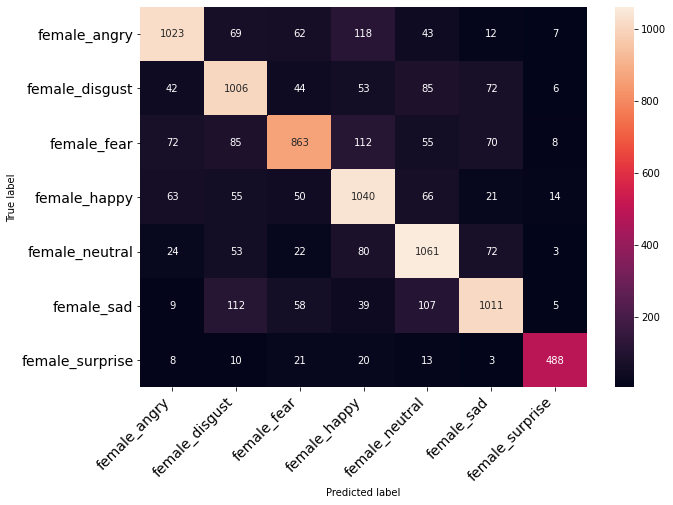

In [ ]:
# Get the predictions file 
finaldf = pd.read_csv("Predictions.csv")
classes = finaldf.actualvalues.unique()
classes.sort()    

# Confusion matrix 
c = confusion_matrix(finaldf.actualvalues, finaldf.predictedvalues)
print(accuracy_score(finaldf.actualvalues, finaldf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [ ]:
# Classification report 
classes = finaldf.actualvalues.unique()
classes.sort()    
print(classification_report(finaldf.actualvalues, finaldf.predictedvalues, target_names=classes))

                 precision    recall  f1-score   support

   female_angry       0.82      0.77      0.79      1334
 female_disgust       0.72      0.77      0.75      1308
    female_fear       0.77      0.68      0.72      1265
   female_happy       0.71      0.79      0.75      1309
 female_neutral       0.74      0.81      0.77      1315
     female_sad       0.80      0.75      0.78      1341
female_surprise       0.92      0.87      0.89       563

       accuracy                           0.77      8435
      macro avg       0.78      0.78      0.78      8435
   weighted avg       0.77      0.77      0.77      8435

